<a href="https://colab.research.google.com/github/hufsaim/T10306201/blob/master/notebook_2023/Lab05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nibabel

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import scipy.signal as signal


## Load Nifti file

In [3]:
h = nib.load('s01.nii.gz')

In [ ]:
print(h)

In [5]:
mri = h.get_fdata()
print(mri.shape)

(256, 256, 32)


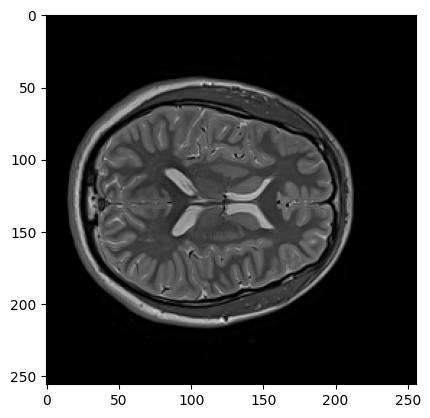

In [6]:
plt.imshow(mri[:,:,20],cmap='gray')

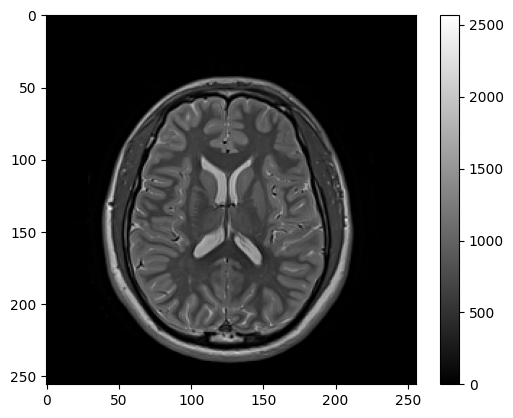

In [7]:
img = mri[::-1,::-1,20].transpose((1,0))
plt.imshow(img,cmap='gray')
plt.colorbar()
plt.show()

## Edge detection - Kirsch Compass Kernels

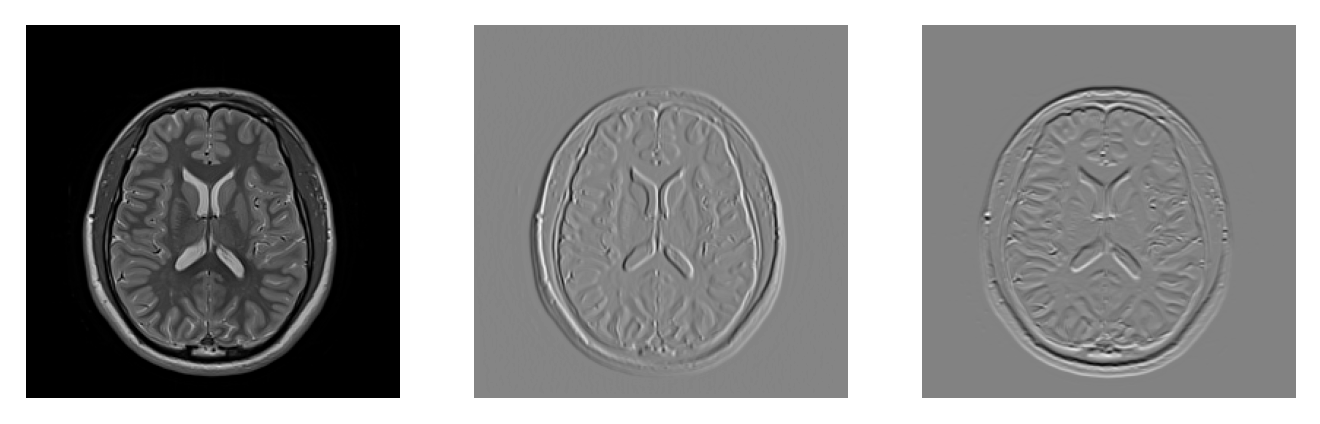

In [8]:
n = np.array([[-3,-3,5],[-3,0,5],[-3,-3,5]])
nw = np.array([[-3,5,5],[-3,0,5],[-3,-3,-3]])
w = np.array([[5,5,5],[-3,0,-3],[-3,-3,-3]])
sw = np.array([[5,5,-3],[5,0,-3],[-3,-3,-3]])
s = np.array([[5,-3,-3],[5,0,-3],[5,-3,-3]])
se = np.array([[-3,-3,-3],[5,0,-3],[5,5,-3]])
e = np.array([[-3,-3,-3],[-3,0,-3],[5,5,5]])
ne = np.array([[-3,-3,-3],[-3,0,5],[-3,5,5]])

plt.figure(dpi=256)
plt.subplot(131)
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.subplot(132)
g = signal.convolve2d(img,n,mode='same')
plt.imshow(g, cmap='gray')
plt.axis('off')
plt.subplot(133)
g = signal.convolve2d(img,e,mode='same')
plt.imshow(g, cmap='gray')
plt.axis('off')
plt.show()

## Thresholding

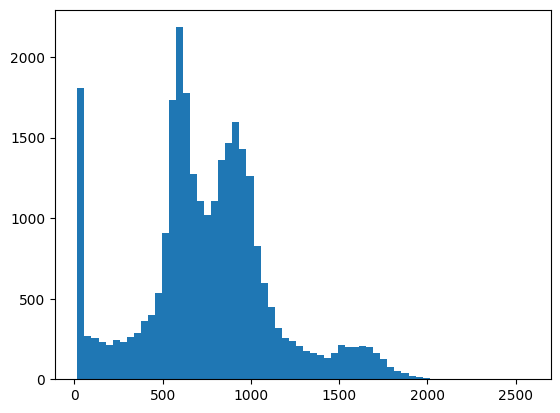

In [9]:
th = 16
plt.hist(img[img>th].ravel(),64)
plt.show()

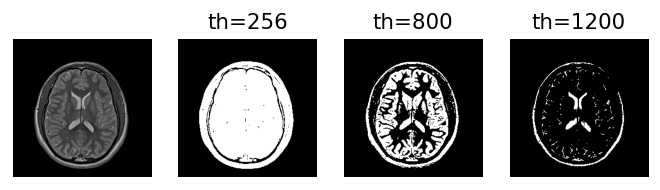

In [10]:
th_vals = [256,800,1200]
plt.figure(dpi=128)
plt.subplot(1,4,1)
plt.imshow(img,cmap='gray')
plt.axis('off')
for n in range(3):
  plt.subplot(1,4,n+2)
  bmsk = img>th_vals[n]
  plt.imshow(bmsk,cmap='gray')
  plt.axis('off')
  plt.title(f'th={th_vals[n]}')
plt.show()

## Noisy image

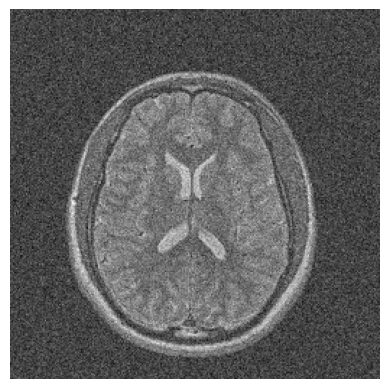

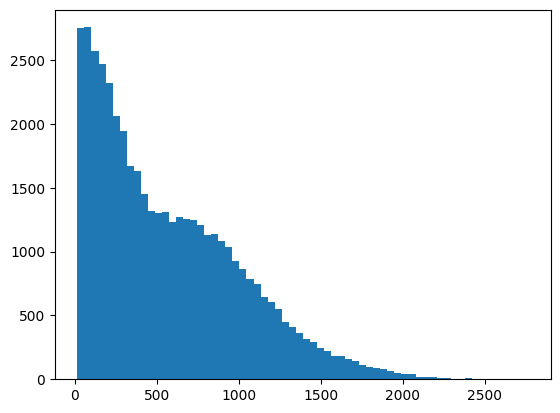

In [11]:
img_n = img + 256*np.random.randn(img.shape[0],img.shape[1])
th = 16

plt.imshow(img_n,cmap='gray')
plt.axis('off')
plt.show()

plt.hist(img_n[img_n>th].ravel(),64)
plt.show()


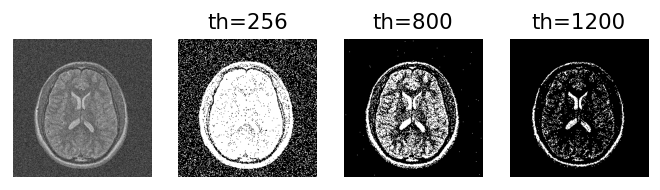

In [12]:
th_vals = [256,800,1200]
plt.figure(dpi=128)
plt.subplot(1,4,1)
plt.imshow(img_n,cmap='gray')
plt.axis('off')
for n in range(3):
  plt.subplot(1,4,n+2)
  bmsk = img_n>th_vals[n]
  plt.imshow(bmsk,cmap='gray')
  plt.axis('off')
  plt.title(f'th={th_vals[n]}')
plt.show()

## Basic Global Thresholding

current threshold:215,m1=431.9370953927056,m2=0.0,dT=214
current threshold:418,m1=830.8377832971127,m2=7.063781092024849,dT=203
current threshold:439,m1=860.1870482917215,m2=17.971073978724437,dT=21
current threshold:441,m1=863.7543060616098,m2=19.975106341840682,dT=2


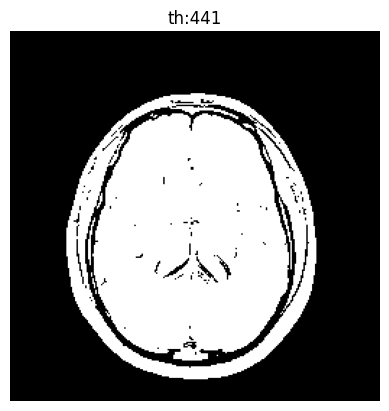

In [13]:
T_init = 1
T = []
T.append(T_init)
dT = 1000
esp = 2
while dT>esp:
  m1 = np.mean(img[img>T[-1]])
  m2 = np.mean(img[img<T[-1]])
  T.append(int(0.5*(m1+m2)))
  dT = np.abs(T[-1]-T[-2])
  print(f'current threshold:{T[-1]},m1={m1},m2={m2},dT={dT}')

bmsk = img>T[-1]
plt.imshow(bmsk,cmap='gray')
plt.axis('off')
plt.title(f'th:{T[-1]}')
plt.show()

## K-means algorithm

In [20]:
E = 1e6
eps = 100
m_vals = np.array([100, 1000, 2000])
m_vals_new = m_vals.copy()
D = np.zeros((len(m_vals),img.shape[0],img.shape[1]))

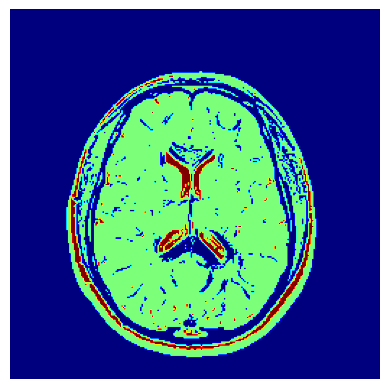

after iteration #1 : [  44  842 1663]
E: 551


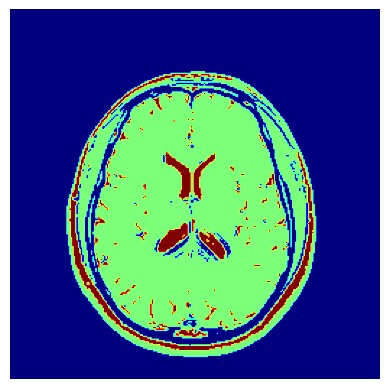

after iteration #2 : [  20  784 1543]
E: 202


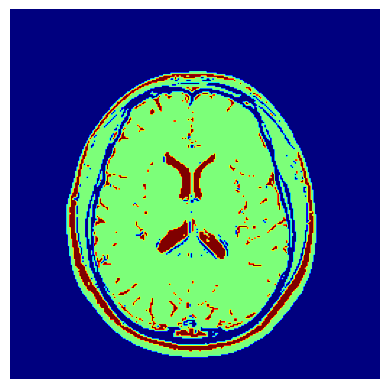

after iteration #3 : [  16  767 1482]
E: 82


In [21]:
n = 0
while E>eps:
  n = n+1
  for k in range(len(m_vals)):
    D[k] = np.abs(img-m_vals[k])
  R = np.argmin(D,axis=0)
  plt.imshow(R,cmap='jet')
  plt.axis('off')
  plt.show()

  for k in range(len(m_vals)):
    m_vals_new[k] = np.mean(img[R==k])
  print(f'after iteration #{n} : {m_vals_new}')
  E = np.sum(np.abs(m_vals_new - m_vals))
  print('E:',E)
  m_vals = m_vals_new.copy()